# Mind Wandering
This notebook documents the mind wandering VR experiment in conjunction with biosignalsplux EEG and fNIRS sensor data.

## Experiment

The experiment induces and measures mind wandering by having the subject identify misspelled words in a long text. When a subject does not identify a misspelled word, we can say that they are not focused and consider them to be "mind-wandering" at that point in the experiment. The experiment controller uses eye tracking to watch the user's vision, so we can tracke exactly where they are in the text throughout the experiment. 

For the subject, the sequence of the experiment is as follows (the subject is wearing a VR headset with eye tracking enabled):

1. Read the tutorial. The tutorial explains the experiment and the controls.
2. Perform trial run. This is the same as the actual experiment, except it is much shorter and there are no misspelled words. It is just a sandbox for the subject to get used to the reading pace and the controls for marking words as misspelled.
3. Read full text. This is where the bulk of the experiment happens. It takes roughly 20 minutes to get through the full text.
4. Answer questions. There are a couple multiple choice questions at the end of the experiment for the subject to answer. The responses are recorded in a json file.

## Images

Below are two images from the subject's perspective in VR. Note that since the subject is in VR these look slightly warped.

![Reading](assets/reading.jpg "Regular Reading")

*Figure 1: An example of what the user might see during the experiment*

![Misspelled](assets/misspelled.jpg "Misspelled Word")

*Figure 2: The user marked the word "potter" as misspelled*

## Example Data and Processing

This notebook contains data from an example run of the experiment. Reza did this with the plux EEG and fNIRS sensors on him. The EEG was set with the active electrode at F7 and the reference at Fp1. The fNIRS was set at the middle of the browline on Fpz.

In [ ]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import biosignalsnotebooks as bsnb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, Markdown

from utils.multitaper_spectogram_python import multitaper_spectrogram

In [ ]:
vr_filepath = "mind-wandering-152412-questions.json"
questions_filepath = "mind-wandering-152412.csv"
plux_filepath = "reza_mind_wandering.txt"

In [11]:
#plux_filepath = "data/eyesopeneyesclosed_jack_11-15-21.txt"

with open(plux_filepath) as plux:
    header = json.loads(plux.readlines()[1][1:])
    
    key = list(header.keys())[0]
    #plux_start = header.get
    #print(json.dumps(header[key], indent=4))
    plux_date = header[key]["date"]
    plux_time = header[key]["time"]

    plux_start = dt.datetime.strptime(plux_date + " " + plux_time, "%Y-%m-%d %H:%M:%S.%f")
   

    plux_sampling_rate = header[key]["sampling rate"]
    plux_resolution = header[key]["resolution"][0]

    plux_columns = header[key]["column"]
    #print(plux_columns)

    #print(plux_sampling_rate, plux_start)

plux_raw = np.loadtxt(plux_filepath, skiprows=3)
plux_data = pd.DataFrame(plux_raw, columns=plux_columns)
plux_data["time"] = plux_data["nSeq"].apply(lambda t: plux_start + dt.timedelta(seconds=t/plux_sampling_rate))

display(plux_data)


,nSeq,DI,CH1,CH9A,CH9B,time
0,0.0,0.0,30760.0,0.0,0.0,2021-12-15 15:00:34.949
1,1.0,0.0,29304.0,0.0,0.0,2021-12-15 15:00:34.950
2,2.0,0.0,28484.0,4527.0,134380.0,2021-12-15 15:00:34.951
3,3.0,0.0,28800.0,4527.0,134380.0,2021-12-15 15:00:34.952
4,4.0,0.0,28840.0,105060.0,174547.0,2021-12-15 15:00:34.953
...,...,...,...,...,...,...
1445845,1445845.0,0.0,34930.0,97021.0,107321.0,2021-12-15 15:24:40.794
1445846,1445846.0,0.0,27624.0,96891.0,107291.0,2021-12-15 15:24:40.795
1445847,1445847.0,0.0,16112.0,96891.0,107291.0,2021-12-15 15:24:40.796
1445848,1445848.0,0.0,7238.0,97911.0,107267.0,2021-12-15 15:24:40.797


Multitaper Spectrogram Properties: 
     Spectral Resolution: 0.08333333333333333Hz
     Window Length: 120.0s
     Window Step: 5.0s
     Time Half-Bandwidth Product: 5
     Number of Tapers: 9
     Frequency Range: 2-50Hz
     Detrend: linear


 Multitaper compute time: 31.82206819999999 seconds


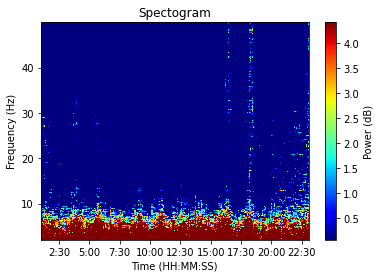

In [12]:
eeg_data = plux_data["CH1"]

eeg_uv = bsnb.raw_to_phy("EEG", "biosignalsplux", eeg_data, plux_resolution, "uV")
time_uv = bsnb.generate_time(eeg_uv, plux_sampling_rate)



plt.title("Spectogram")

spect, stimes, sfreqs = multitaper_spectrogram(eeg_uv, plux_sampling_rate, frequency_range=[2, 50], window_params=[120, 5])

In [17]:
with open("mind-wandering-152412-questions.json") as f:
    questions = json.load(f)

display(Markdown("## End of Experiment Survey Questions"))

for q in questions["questions"]:
    display(Markdown(f"**{q['question']}**"))
    display(Markdown(f"*{q['choice']}*"))

## End of Experiment Survey Questions

**Are you ready to begin?**

*Yes*

**After how many hours the pill lost its effect?**

*2 hours*

**Did you mind wander reading the essay?**

*Yes*

**Approximately, how many times did you mind wander?**

*More than 5 times*

**Was the essay too hard to understand?**

*Yes*

**Did you skip some parts of the text?**

*Yes*